# Time Series Anaysis

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

#from IPython.display import Image

import seaborn as sns
sns.set()

%matplotlib inline


# Exploration of the Bay Area Rapid Transit (BART) data 
Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [59]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv')

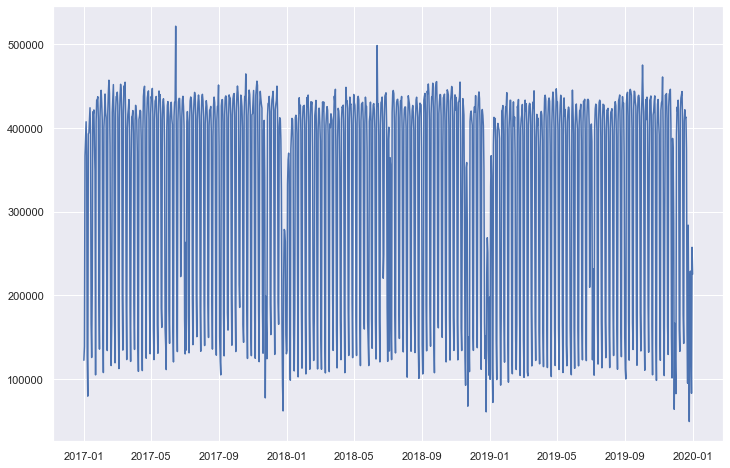

In [60]:
bart['date'] = pd.to_datetime(bart['date'])
plt.plot(bart['date'],bart['passenger']);

### Task 1, use linear regression to explore the trends over 3 years, and report if there is a significant trend in the BART data.
Hint: use the index to represent the day count from the first day of the period.

In [61]:
bart.tail()

,date,passenger
1090,2019-12-27,229101
1091,2019-12-28,136422
1092,2019-12-29,83354
1093,2019-12-30,257428
1094,2019-12-31,225352


In [62]:
#exploratory analysis
nsamp1 = len(bart)

# convert the `date` feature into `dt.datetime` format. This is for later datetime operations
Time1 = bart['date'].values

# print dataset characteristics
print('This is the original dataset characteristics:')
timeperiod1 = Time1[-1] - Time1[0] + pd.to_timedelta(1,unit='day')

# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ', timeperiod1.days)
print('The number of observations are: ', nsamp1)
print(bart.describe())

This is the original dataset characteristics:
The time period for this dataset is:  1095
The number of observations are:  1095
           passenger
count    1095.000000
mean   330573.682192
std    128462.319166
min     49728.000000
25%    177521.000000
50%    407128.000000
75%    428066.500000
max    521066.000000


In [63]:
lm=sm.OLS(bart.passenger,sm.add_constant(bart.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Sun, 20 Feb 2022   Prob (F-statistic):              0.132
Time:                        21:35:16   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

##### The p-value for the coef of x1 is 0.132, so the trend is not significant.

### Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

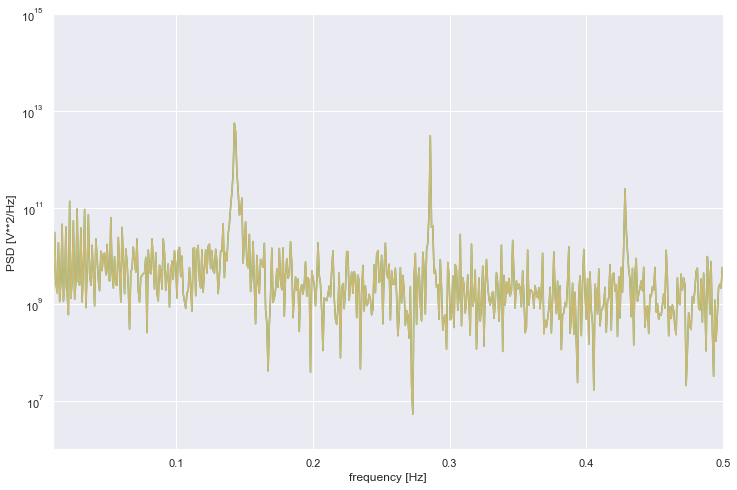

Strongest period for passenger = 7.019230769230769


In [67]:
f, PSD = scipy.signal.periodogram(bart.passenger)
f2, PSD2 = scipy.signal.periodogram(bart.passenger)
plt.semilogy(f, PSD, 'g')
plt.semilogy(f2, PSD2, 'y')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0.01,0.5) #period from 2 to 100 days
plt.ylim(1e6,1e15)
plt.show()
PSD = PSD[f>0.01]; f = f[f>0.01]
PSD2 = PSD2[f2>0.01]; f2 = f2[f2>0.01]
print('Strongest period for passenger = {}'.format(1/f2[np.argmax(PSD2)]))

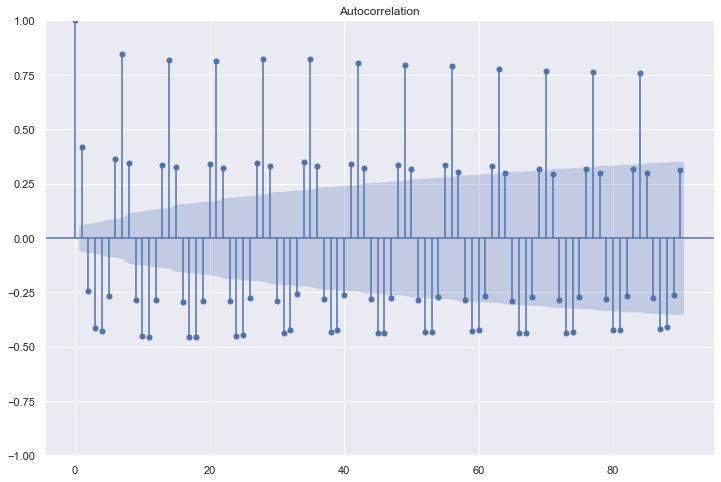

In [71]:
plot_acf(bart.passenger, lags = 90);

### Task 3 Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [70]:
bart['DOW'] = pd.to_datetime(bart.date).dt.dayofweek

In [72]:
#without an intercept
X = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=False)],axis=1)
lmBart=sm.OLS(bart.passenger[:730],X[:730]).fit()
print (lmBart.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Sun, 20 Feb 2022   Prob (F-statistic):          3.58e-275
Time:                        21:38:10   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

(-1000.0, 500000.0)

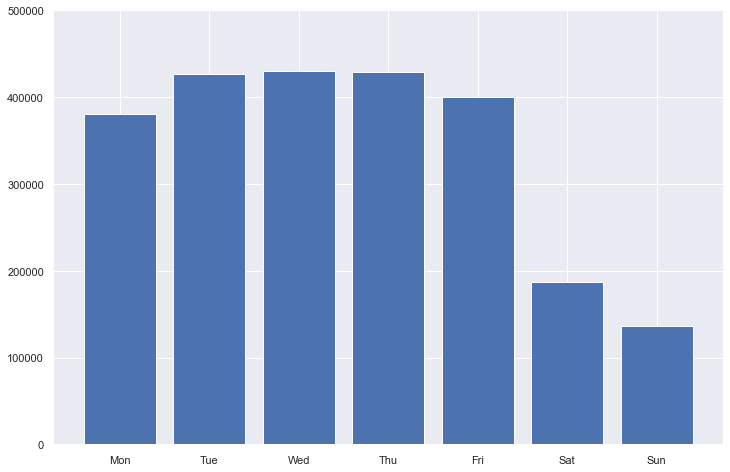

In [73]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmBart.params[1:].tolist())
plt.ylim([-1000,500000])

### Without intercept: the coefficients for each day of the week are significant.

In [74]:
#use intercept
X2 = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=True)],axis=1)
X2 = sm.add_constant(X2) #use intercept instead of an exluded dummy for Monday; other dummies will be relative
lmBart2=sm.OLS(bart.passenger[:730],X2[:730]).fit()
print (lmBart2.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Sun, 20 Feb 2022   Prob (F-statistic):          3.58e-275
Time:                        21:38:15   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.81e+05   6096.367     62.495      0.0

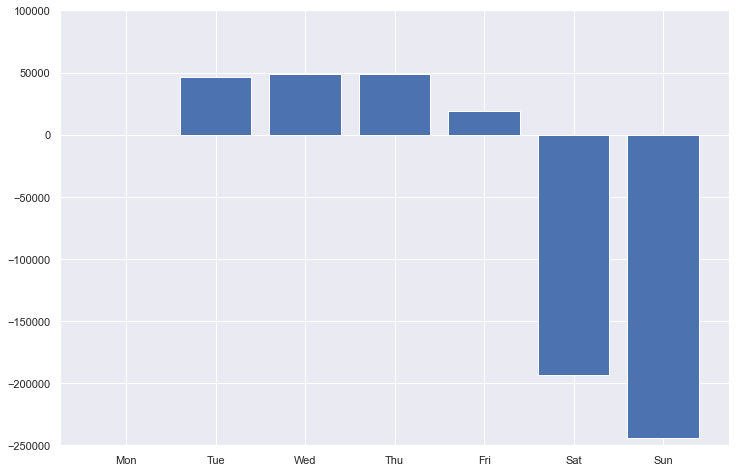

In [75]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        [0] + lmBart2.params[2:].tolist())
plt.ylim([-250000,100000]);
plt.show()

### With intercept: the coefficients for each day of the week are significant.

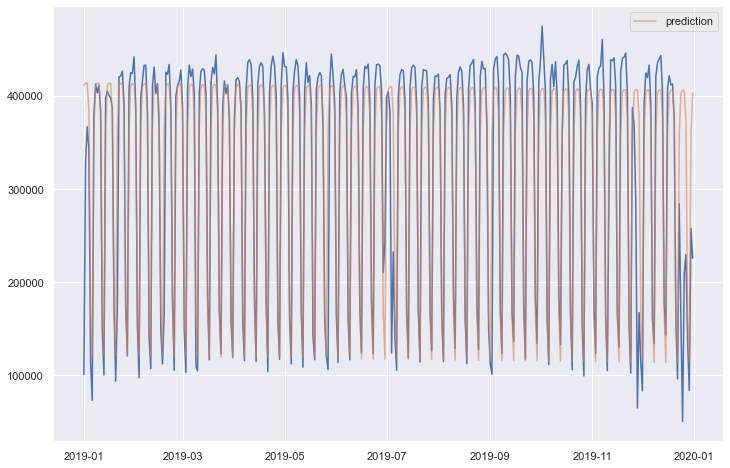

In [76]:
#use the model lmbart trained over 2017-2018 to predict 2019 passenger
y = lmBart.predict(X[730:])
#visualize the actual passenger vs the model prediction
plt.plot(bart.date[730:],bart.passenger[730:])
plt.plot(bart.date[730:],y,label='prediction',alpha=0.6)
plt.legend()

### Task 4, plot results and report in-sample (2017-2018) and out-of-sample (2019) predictions (same plot, different colors). Report in-sample and out-of-sample $R^2$

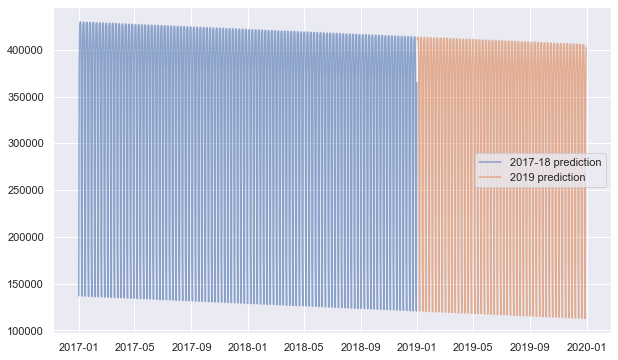

In [77]:
plt.figure(figsize=(10,6))
y_train=lmBart.predict(X[:730])
plt.plot(bart.date[:730],y_train,label='2017-18 prediction',alpha=0.6)
plt.plot(bart.date[730:],y,label='2019 prediction',alpha=0.6)
plt.legend()

In [78]:
#In-sample(2017-2018) R-square
r2_score(bart.passenger[:730],y_train)

0.8324941917707158

In [79]:
#Out-of-sample(2019) R-square
r2_score(bart.passenger[730:],y)

0.8203089387540557

### Task 5, Use the "multiplicative" seasonal_decompose with 7 day period to decompose the BART data and detect outliers based on the top and bottom 2.5% of the residuals

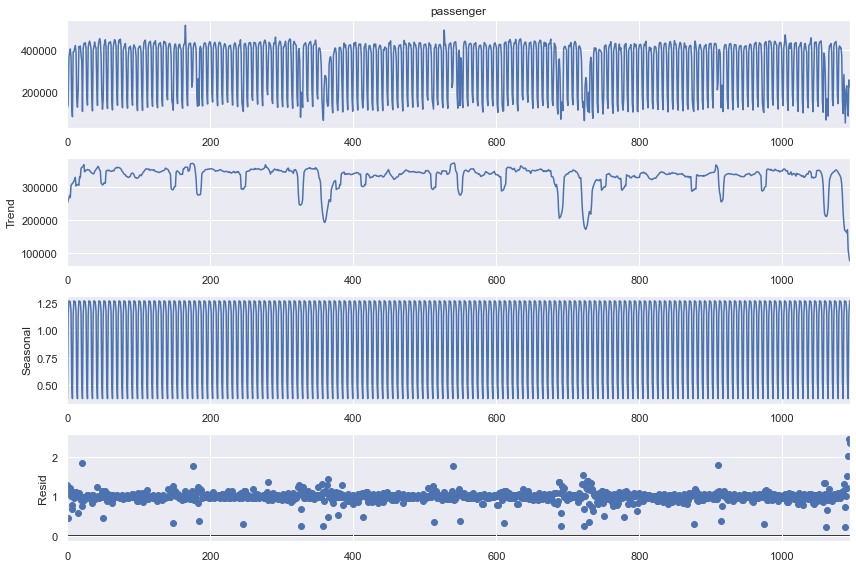

In [78]:
daySeries1 = bart['passenger']
dailyDecomp1 = seasonal_decompose(daySeries1, model='multicative', period = 7, extrapolate_trend='freq')
residualMult1 = np.array(dailyDecomp1.resid)
resMult1 = dailyDecomp1.resid
fig = dailyDecomp1.plot();

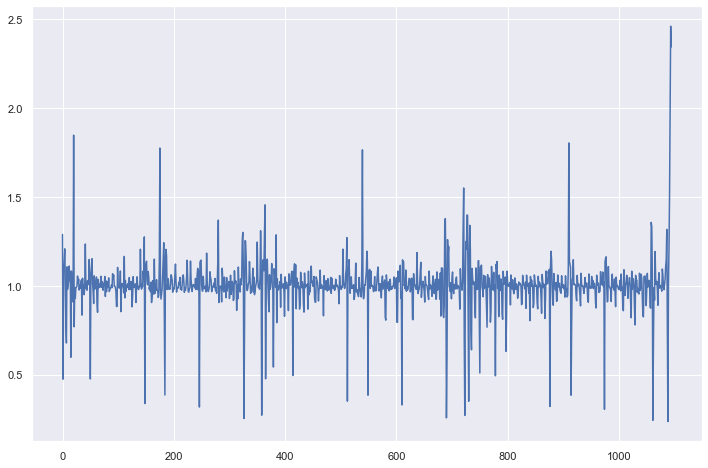

In [79]:
plt.show()
plt.plot(resMult1)

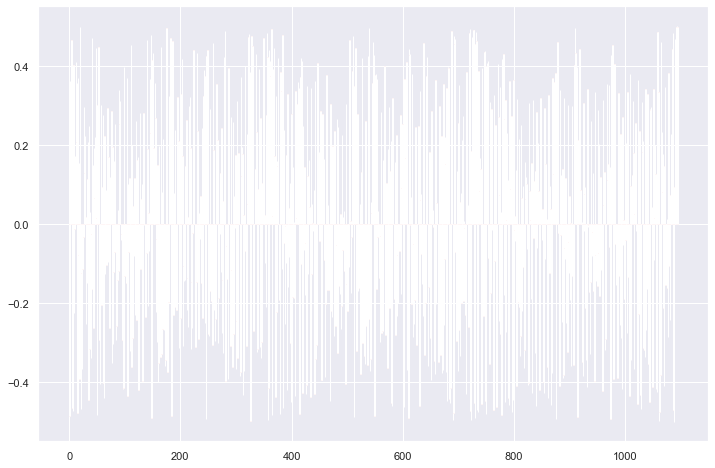

In [80]:
outlierData1 = pd.DataFrame()
outlierData1['Res'] = residualMult1
outlierData1['Percentile_rank'] = outlierData1.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData1)), outlierData1['Percentile_rank'], color='red')
plt.show()

In [81]:
bart.date[outlierData1['Percentile_rank']>0.475]

0      2017-01-01
20     2017-01-21
147    2017-05-28
175    2017-06-25
280    2017-10-08
324    2017-11-21
356    2017-12-23
363    2017-12-30
364    2017-12-31
384    2018-01-20
511    2018-05-27
539    2018-06-24
687    2018-11-19
688    2018-11-20
692    2018-11-24
720    2018-12-22
721    2018-12-23
727    2018-12-29
728    2018-12-30
732    2019-01-03
910    2019-06-30
1058   2019-11-25
1059   2019-11-26
1086   2019-12-23
1091   2019-12-28
1092   2019-12-29
1093   2019-12-30
1094   2019-12-31
Name: date, dtype: datetime64[ns]

In [82]:
bart.date[outlierData1['Percentile_rank']<-0.475]

1      2017-01-02
15     2017-01-16
50     2017-02-20
148    2017-05-29
184    2017-07-04
246    2017-09-04
326    2017-11-23
358    2017-12-25
365    2018-01-01
379    2018-01-15
414    2018-02-19
512    2018-05-28
549    2018-07-04
610    2018-09-03
690    2018-11-22
691    2018-11-23
723    2018-12-25
730    2019-01-01
735    2019-01-06
750    2019-01-21
778    2019-02-18
797    2019-03-09
876    2019-05-27
914    2019-07-04
974    2019-09-02
1061   2019-11-28
1088   2019-12-25
Name: date, dtype: datetime64[ns]